# Time series

In [125]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tsa.arima.model import ARIMA
import itertools
from prophet import Prophet
from scipy import signal
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', RuntimeWarning)

In [126]:
data = pd.read_csv('data/clean_data.csv')
data = data.drop(data.columns[0], axis=1)
data['Date'] = pd.to_datetime(data['Date'])

## Data preparation
### Seasonality in Adj Close

Seasonality is checked on Adj Close column, seasonality strength is calculated by formula:

Stationarity is checked using Augmented Dickey Fuller method.

In [127]:
grouped = data.groupby('Symbol')

In [128]:
def check_seasonality(stock_data, column='Adj Close', period=365):
    try:
        result = seasonal_decompose(stock_data[column], model='multiplicative', period=period)

        seasonal = result.seasonal
        residual = result.resid

        variance_residual = residual.var()
        variance_seasonal = seasonal.var()

        seasonality_strength = max(0, 1 - (variance_residual / (variance_residual + variance_seasonal)))

        return seasonality_strength
    except ValueError as e:
        print("Caught an error:", e)
        return None

seasonality_results = {}
for symbol, stock_data in grouped:
    if len(stock_data) > 365:
        seasonality_strength = check_seasonality(stock_data)
        seasonality_results[symbol] = {
            'seasonality_strength': seasonality_strength
        }

seasonality_df = pd.DataFrame.from_dict(seasonality_results, orient='index')

In [129]:
seasonality_threshold = 0.9
significant_seasonal_stocks = seasonality_df[
    (seasonality_df['seasonality_strength'] > seasonality_threshold)
    ]

print(significant_seasonal_stocks)

      seasonality_strength
INVH               0.99317


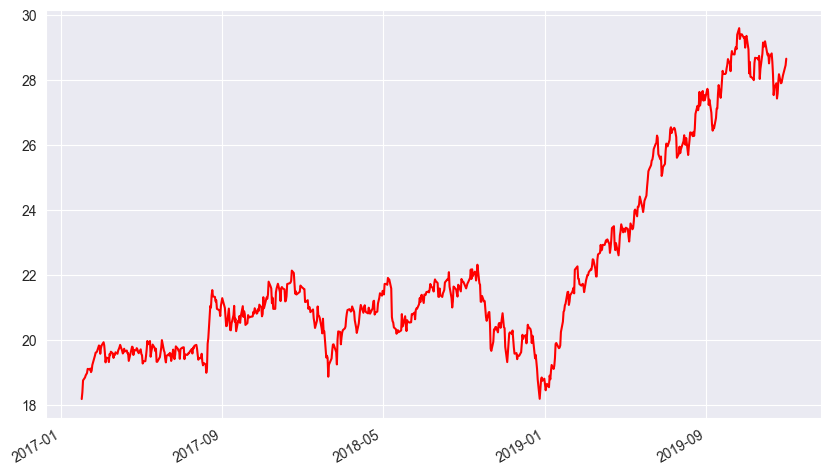

In [130]:
invh_data = data[data['Symbol'] == 'INVH'].copy()

plt.figure(figsize=(10, 6))
plt.plot(invh_data['Date'], invh_data['Adj Close'], color='red')

xticks = plt.gca().get_xticks()
xticks_labels = plt.gca().get_xticklabels()

plt.gca().set_xticks(xticks[::2])
plt.gca().set_xticklabels(xticks_labels[::2])

plt.gcf().autofmt_xdate()

plt.show()

### 1. Seasonal Decomposition Plots

Seasonal decomposition involves breaking down a time series into three components:

- Trend: The long-term movement or direction in the data.
- Seasonal: The repeating pattern or cycle within a specific period.
- Residual: The remaining part after removing the trend and seasonal components, representing irregular or random noise.

In the plots created by the seasonal_decompose function, you'll see four subplots:

- Observed: The original time series data.
    This is the actual adjusted close prices for the stock over time.
    It shows how the stock's price fluctuates with all its components combined.

- Trend: The long-term trend component of the time series.
    It shows the overall direction (upwards, downwards, or flat) over a longer period, smoothing out short-term fluctuations.
    Helps to understand the general movement of the stock price over time.

- Seasonal: The seasonal component of the time series.
    It reveals repeating patterns or cycles within the data, such as annual cycles.
    This component shows the periodic fluctuations that occur within a specific period (e.g., yearly for annual seasonality).
    High seasonality strength indicates prominent cyclical patterns.

- Residual: The residual component after removing the trend and seasonal components.
    It represents the noise or irregular variations not captured by the trend or seasonal components.
    Helps to identify any unusual events or outliers that affect the stock price.

### 2. Autocorrelation Function (ACF) Plots

The ACF plot shows the correlation of the time series with its own lagged values. It helps to identify the presence and strength of periodic patterns. Here's what the ACF plot tells you:

- Lag: The x-axis represents the lag (number of periods back) at which the autocorrelation is calculated.
    For example, a lag of 1 represents correlation with the previous day, a lag of 2 represents correlation with two days ago, and so on.

- Autocorrelation: The y-axis represents the correlation coefficient, ranging from -1 to 1.
    A value close to 1 indicates a strong positive correlation.
    A value close to -1 indicates a strong negative correlation.
    A value around 0 indicates no correlation.

- Significant Lags: The spikes that exceed the confidence intervals (typically shown as horizontal dashed lines) are considered significant.
    Significant spikes at specific lags indicate the presence of repeating patterns.
    For example, a significant spike at a lag of 365 days would suggest annual seasonality.

In [131]:
significant_symbols = significant_seasonal_stocks.index.tolist()

def plot_seasonality(stock_data, symbol, column='Adj Close'):
    result = seasonal_decompose(stock_data[column], model='additive', period=365)
    result.plot()
    plt.suptitle(f'{symbol}')
    plt.subplots_adjust(top=0.85)
    plt.show()

def plot_acf_seasonality(stock_data, symbol, column='Adj Close'):
    plt.figure()
    plot_acf(stock_data[column].dropna(), lags=365)
    plt.title(f'ACF for {symbol}', fontsize=16)
    plt.show()
        

<Figure size 640x480 with 0 Axes>

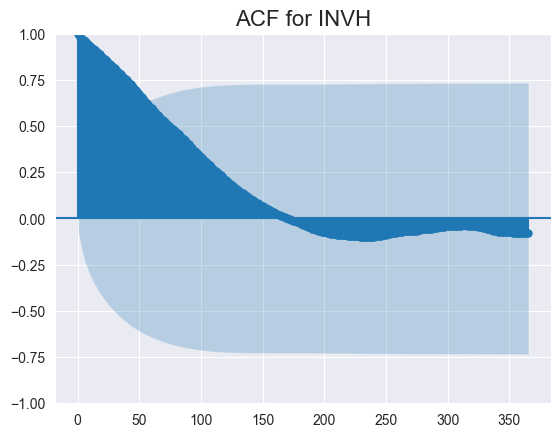

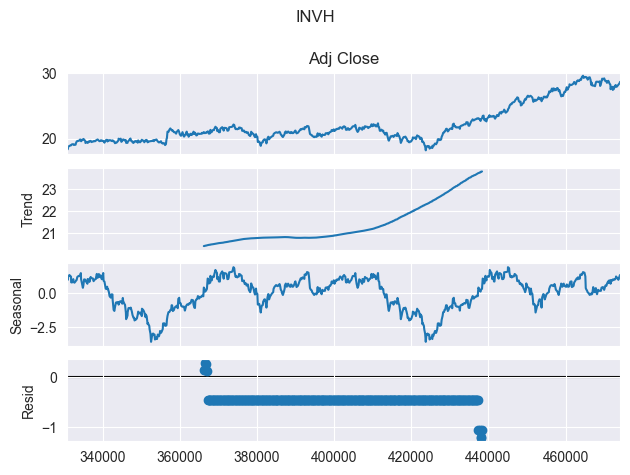

In [132]:
for symbol in significant_symbols:
    stock_data = grouped.get_group(symbol)
    if len(stock_data) > 365:
        plot_acf_seasonality(stock_data, symbol)
        plot_seasonality(stock_data, symbol)

## Exponential smoothing

          RMSE       MAE
INVH  2.962089  2.431127


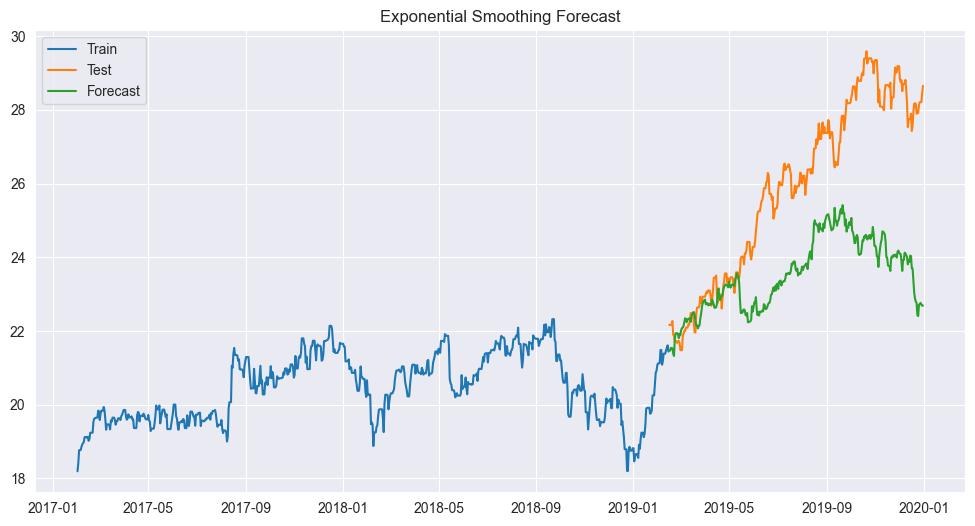

In [133]:
warnings.simplefilter('ignore', ConvergenceWarning)

def exponential_smoothing_forecast(stock_data, column='Adj Close'):
    stock_data.set_index('Date', inplace=True)
    stock_data = stock_data.asfreq('D').ffill()

    train, test = train_test_split(stock_data[column], train_size=0.7, shuffle=False)

    model = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=365)
    fit = model.fit(optimized=True)
    forecast = fit.forecast(len(test))

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.legend(loc='best')
    plt.title('Exponential Smoothing Forecast')

    return rmse, mae

results = {}
for symbol in significant_seasonal_stocks.index:
    stock_data = data[data['Symbol'] == symbol]
    rmse, mae = exponential_smoothing_forecast(stock_data)
    results[symbol] = {'RMSE': rmse, 'MAE': mae}

results_df = pd.DataFrame.from_dict(results, orient='index')

print(results_df)


In [134]:
def optimize_exponential_smoothing(stock_data, column='Adj Close'):
    best_rmse = float('inf')
    best_mae = float('inf')
    best_params = None
    best_fit = None
    stock_data.set_index('Date', inplace=True)
    stock_data = stock_data.asfreq('D').ffill()
    train, test = train_test_split(stock_data[column], train_size=0.7, shuffle=False)

    for trend in ['add', 'mul']:
        for seasonal in ['add', 'mul']:
            try:
                model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=365)
                fit = model.fit(optimized=True)
                forecast = fit.forecast(len(test))

                rmse = np.sqrt(mean_squared_error(test, forecast))
                mae = mean_absolute_error(test, forecast)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_mae = mae
                    best_params = (trend, seasonal)
                    best_fit = fit
            except:
                continue

    return best_params, best_rmse, best_mae, best_fit

optimized_results = {}
for symbol in significant_seasonal_stocks.index:
    stock_data = data[data['Symbol'] == symbol]
    best_params, best_rmse, best_mae, best_fit = optimize_exponential_smoothing(stock_data)
    optimized_results[symbol] = {
        'Best Params': best_params,
        'Best RMSE': best_rmse,
        'Best MAE': best_mae
    }

optimized_results_df = pd.DataFrame.from_dict(optimized_results, orient='index')
print(optimized_results_df)

     Best Params  Best RMSE  Best MAE
INVH  (mul, mul)   2.962089  2.431127


## ARIMA

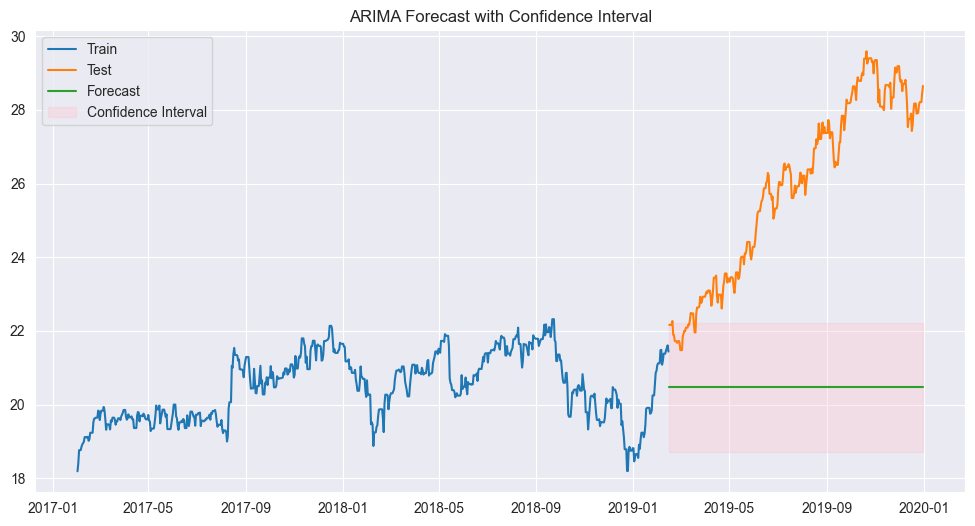

          RMSE       MAE
INVH  5.925447  5.419108


In [135]:
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', ValueWarning)

def arima_forecast(stock_data, column='Adj Close'):
    stock_data.set_index('Date', inplace=True)
    stock_data = stock_data.asfreq('D').ffill()
    train, test = train_test_split(stock_data[column], train_size=0.7, shuffle=False)

    model = ARIMA(train, order=(0, 0, 0))
    fit_model = model.fit()

    forecast = fit_model.forecast(steps=len(test))
    forecast_conf_int = fit_model.get_forecast(steps=len(test)).conf_int()

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.fill_between(test.index,
                     forecast_conf_int.iloc[:, 0],
                     forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
    plt.legend(loc='best')
    plt.title('ARIMA Forecast with Confidence Interval')
    plt.show()

    return rmse, mae

results = {}
for symbol in significant_seasonal_stocks.index:
    stock_data = data[data['Symbol'] == symbol]
    rmse, mae = arima_forecast(stock_data)
    results[symbol] = {'RMSE': rmse, 'MAE': mae}

results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

In [136]:
def arima_forecast(stock_data, order, column='Adj Close', plot=False):
    stock_data.set_index('Date', inplace=True)
    stock_data = stock_data.asfreq('D').ffill()
    train, test = train_test_split(stock_data[column], train_size=0.7, shuffle=False)

    model = ARIMA(train, order=order)
    fit_model = model.fit()

    forecast = fit_model.forecast(steps=len(test))
    forecast_conf_int = fit_model.get_forecast(steps=len(test)).conf_int()

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    if plot:
        plt.figure(figsize=(12, 6))
        plt.plot(train.index, train, label='Train')
        plt.plot(test.index, test, label='Test')
        plt.plot(test.index, forecast, label='Forecast')
        plt.fill_between(test.index,
                         forecast_conf_int.iloc[:, 0],
                         forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')
        plt.legend(loc='best')
        plt.title(f'ARIMA Forecast with order={order}')

    return rmse, mae


           RMSE       MAE
0 0 0  5.925447  5.419108
1 0 0  5.928998  5.322496
2 0 0  5.931431  5.327533
3 0 0  5.928036  5.320951
4 0 0  5.936063  5.337005


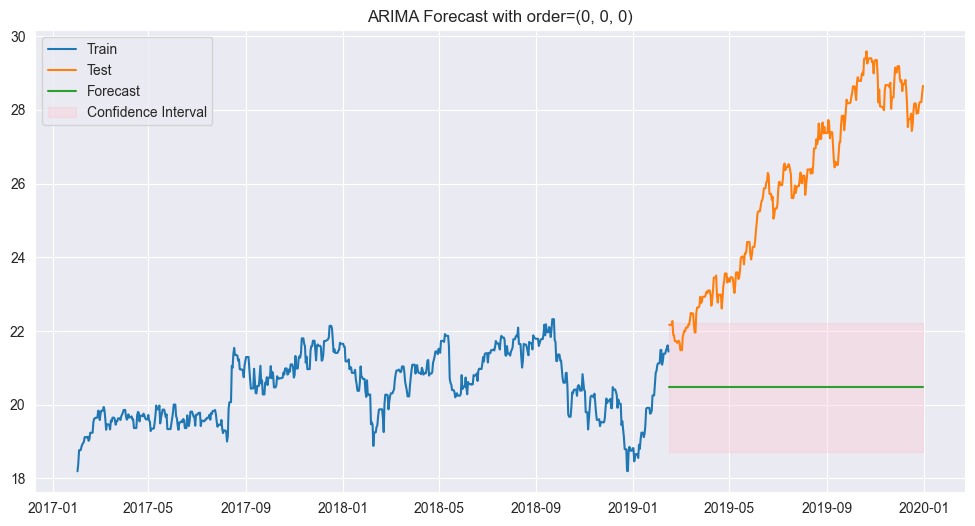

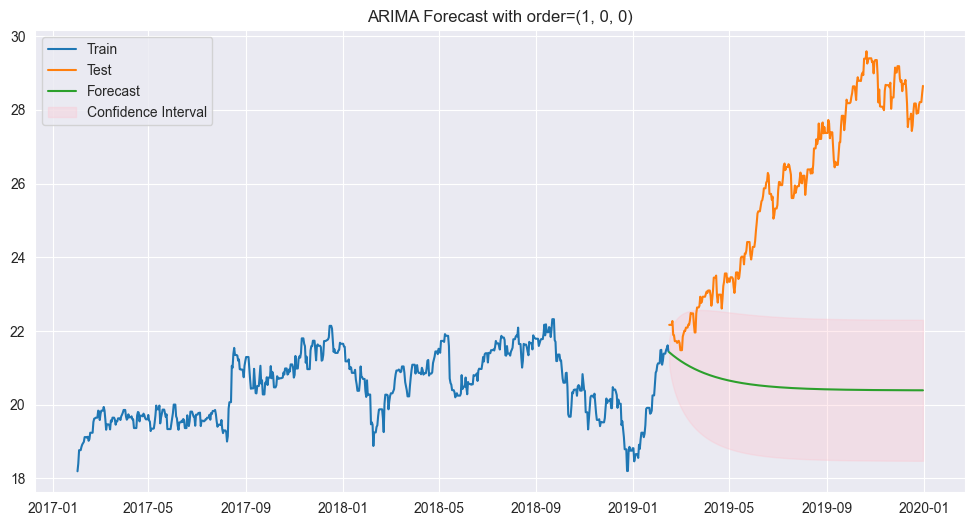

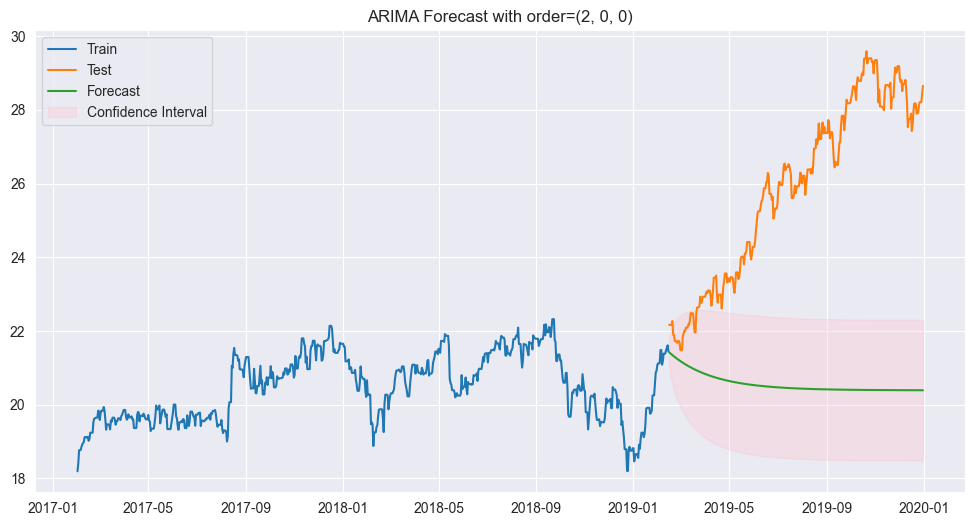

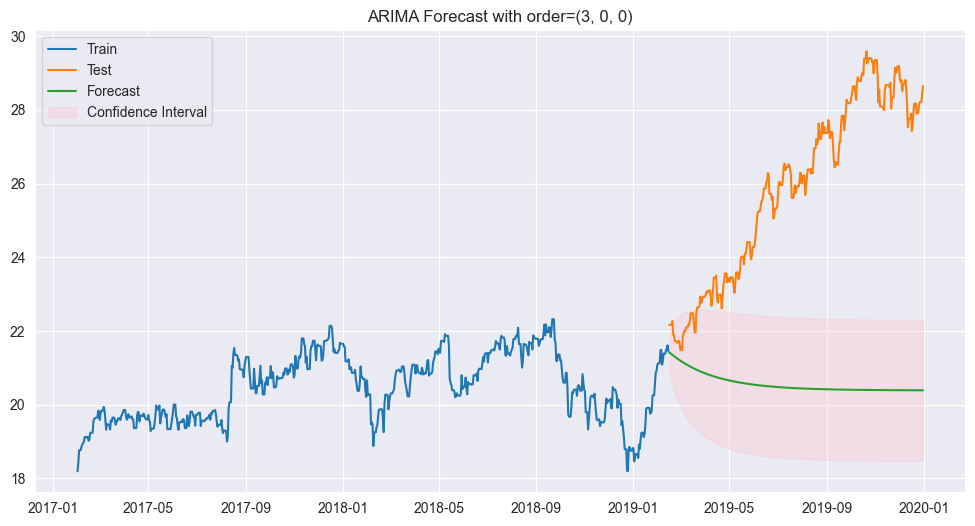

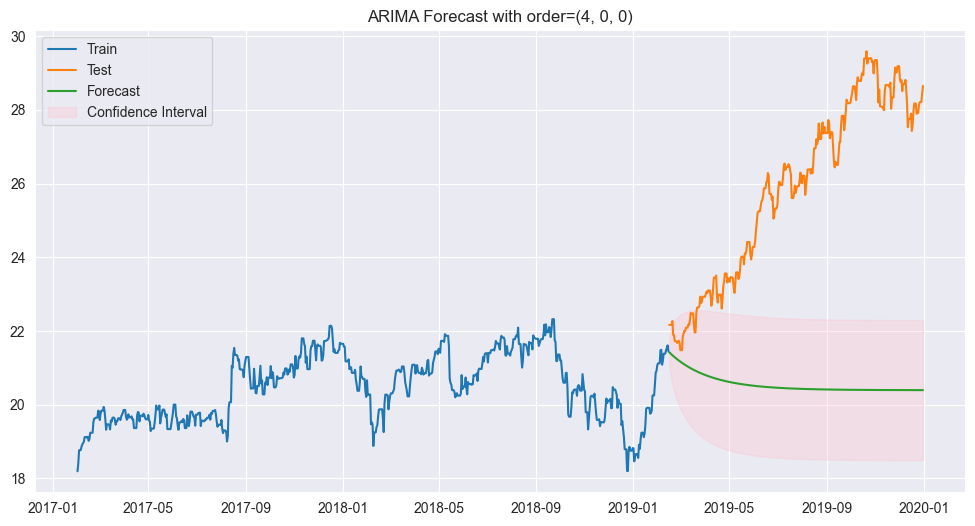

In [137]:
results_p = {}
p_values = [0, 1, 2, 3, 4]

for p in p_values:
    stock_data = data[data['Symbol'] == 'INVH']
    rmse, mae = arima_forecast(stock_data, order=(p, 0, 0), plot=True)
    results_p[(p, 0, 0)] = {'RMSE': rmse, 'MAE': mae}

results_p_df = pd.DataFrame.from_dict(results_p, orient='index')
print(results_p_df)

            RMSE        MAE
0 0 0   5.925447   5.419108
  1 0   5.053626   4.449151
  2 0  36.421051  31.675080


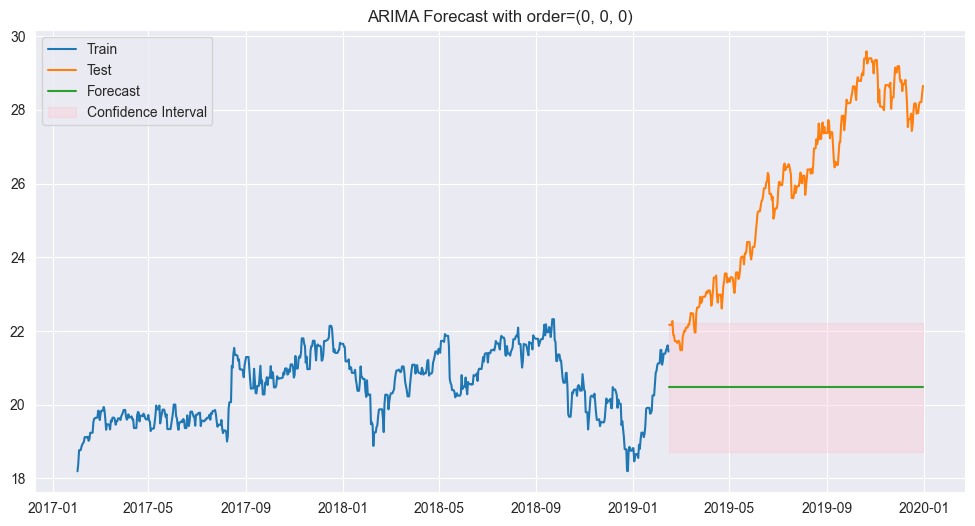

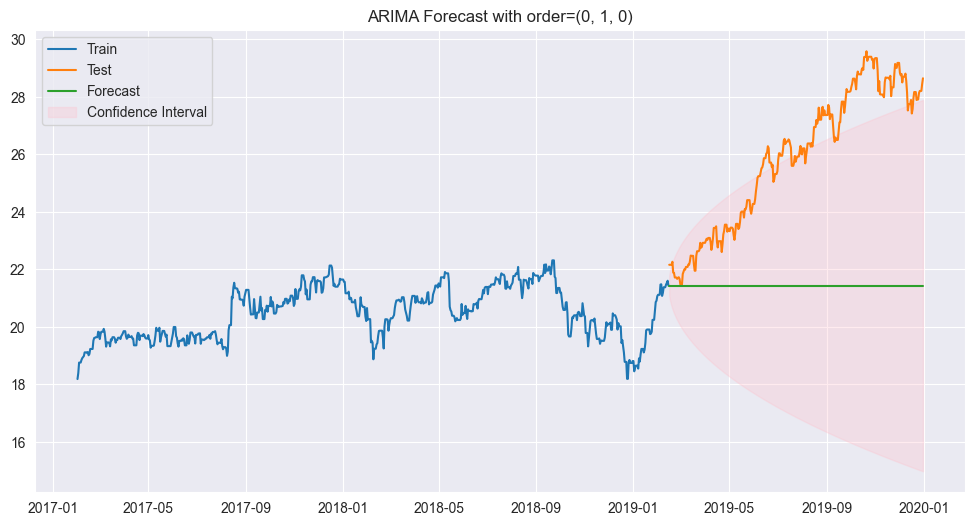

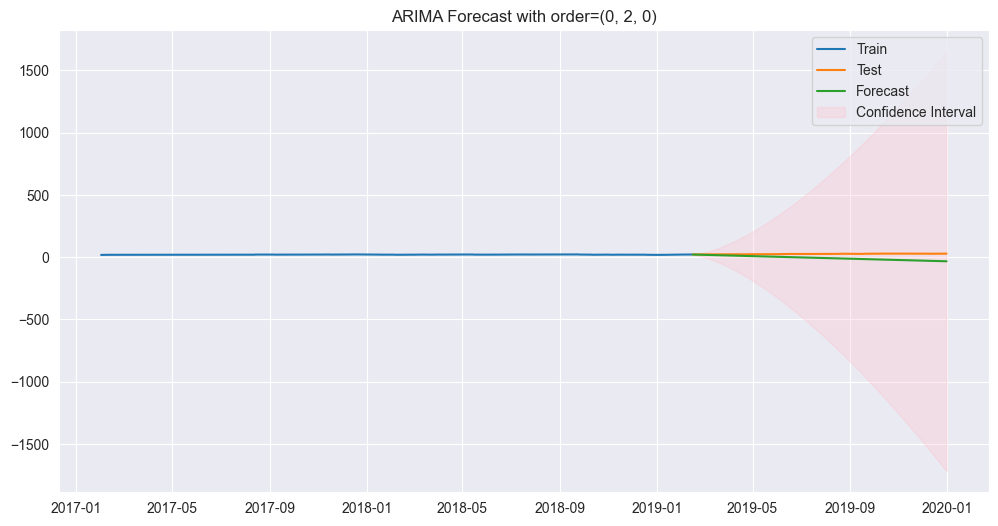

In [138]:
results_d = {}
d_values = [0, 1, 2]

for d in d_values:
    stock_data = data[data['Symbol'] == 'INVH']
    rmse, mae = arima_forecast(stock_data, order=(0, d, 0), plot=True)
    results_d[(0, d, 0)] = {'RMSE': rmse, 'MAE': mae}

results_d_df = pd.DataFrame.from_dict(results_d, orient='index')
print(results_d_df)

In [139]:
results_q = {}
q_values = [75]

for q in q_values:
    stock_data = data[data['Symbol'] == 'IBM']
    rmse, mae = arima_forecast(stock_data, order=(0, 0, q), plot=True)
    results_q[(0, 0, q)] = {'RMSE': rmse, 'MAE': mae}

results_q_df = pd.DataFrame.from_dict(results_q, orient='index')
print(results_q_df)

KeyboardInterrupt: 

In [ ]:
p_values = [0, 1, 2, 3, 4]
d_values = [0, 1, 2]
q_values = [3, 5, 7]

results_optimized = {}
combinations = list(itertools.product(p_values, d_values))

for combination in combinations:
    stock_data = data[data['Symbol'] == 'IBM']
    rmse, mae = arima_forecast(stock_data, order=combination)
    results_optimized[combination] = {'RMSE': rmse, 'MAE': mae}

results_optimized_df = pd.DataFrame.from_dict(results_optimized, orient='index')

best_combination = results_optimized_df['RMSE'].idxmin()
print(f'Best combination: {best_combination}')
stock_data = data[data['Symbol'] == 'IBM']
rmse, mae = arima_forecast(stock_data, order=best_combination, plot=True)
print(f'Best combination RMSE: {rmse}, MAE: {mae}')

In [ ]:
def sarima_forecast(stock_data, order, seasonal_order, column='Adj Close'):
    train, test = train_test_split(stock_data[column], train_size=0.7, shuffle=False)

    model = ARIMA(train, order=order, seasonal_order=seasonal_order)
    fit_model = model.fit()

    forecast = fit_model.forecast(steps=len(test))
    forecast_conf_int = fit_model.get_forecast(steps=len(test)).conf_int()

    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)

    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test')
    plt.plot(test.index, forecast, label='Forecast')
    plt.fill_between(test.index,
                     forecast_conf_int.iloc[:, 0],
                     forecast_conf_int.iloc[:, 1], color='pink', alpha=0.05, label='Confidence Interval')
    plt.legend(loc='best')
    plt.title(f'ARIMA Forecast with order={order} and seasonal_order={seasonal_order}')

    return rmse, mae

results_seasonal = {}
seasonal_order_values = [(4, 0, 1, 6), (4, 0, 1, 10), (4, 0, 1, 8), (4, 0, 1, 12)]

for seasonal_order in seasonal_order_values:
    stock_data = data[data['Symbol'] == 'IBM']
    rmse, mae = sarima_forecast(stock_data, order=best_combination, seasonal_order=seasonal_order)
    results_seasonal[seasonal_order] = {'RMSE': rmse, 'MAE': mae}

results_seasonal_df = pd.DataFrame.from_dict(results_seasonal, orient='index')
print(results_seasonal_df)

## Facebook prophet

In [ ]:
def prepare_prophet_data(stock_data, column='Adj Close'):
    df = stock_data.reset_index()[['Date', column]].rename(columns={'Date': 'ds', column: 'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    return df

def train_prophet_model(df):
    train, test = train_test_split(df, train_size=0.7, shuffle=False)
    holidays = pd.DataFrame({
        'holiday': 'stock_crash',
        'ds': pd.to_datetime(['2008-07-11', '2020-02-20']),
        'lower_window': 0,
        'upper_window': 1,
    })
    model = Prophet(holidays=holidays)
    
    model.add_seasonality(name='yearly', period=365, fourier_order=10)
    
    model.fit(train)

    future = model.make_future_dataframe(periods=len(test), freq='D')
    forecast = model.predict(future)

    return model, forecast, train, test

def evaluate_forecast(test, forecast):
    test_values = test['y'].values
    forecast_values = forecast['yhat'][-len(test):].values

    rmse = np.sqrt(mean_squared_error(test_values, forecast_values))
    mae = mean_absolute_error(test_values, forecast_values)

    return rmse, mae

def plot_forecast(model, forecast, train, test):
    plt.figure(figsize=(12, 6))
    plt.plot(train['ds'], train['y'], label='Train')
    plt.plot(test['ds'], test['y'], label='Test')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
    plt.legend(loc='best')
    plt.title('Prophet Forecast')

    model.plot_components(forecast)

results = {}
for symbol in significant_seasonal_stocks.index:
    stock_data = data[data['Symbol'] == symbol]
    stock_data = prepare_prophet_data(stock_data)
    
    model, forecast, train, test = train_prophet_model(stock_data)
    rmse, mae = evaluate_forecast(test, forecast)
    results[symbol] = {'RMSE': rmse, 'MAE': mae}

    plot_forecast(model, forecast, train, test)

results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

## Random Forrest Regressor

In [ ]:
def random_forest_forecast(stock_data, target='Adj Close'):
    X = stock_data.drop(columns=[target, 'Symbol', 'Id', 'Date'])
    y = stock_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)

    plt.figure(figsize=(12, 6))
    plt.plot(X_train.index, y_train, label='Train')
    plt.plot(X_test.index, y_test, label='Test')
    plt.plot(X_test.index, predictions, label='Forecast')
    plt.legend(loc='best')
    plt.title('Random Forest Forecast')

    return rmse, mae

results = {}
for symbol in significant_seasonal_stocks.index:
    stock_data = data[data['Symbol'] == symbol]
    rmse, mae = random_forest_forecast(stock_data)
    results[symbol] = {'RMSE': rmse, 'MAE': mae}

results_df = pd.DataFrame.from_dict(results, orient='index')

print(results_df)

Random forrest generator seems to always "undershoot" the value. Error is also higher than in other methods.

## Generated signal

In [ ]:
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t)
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63)
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

last_n_rows = 600
n_train_rows = 500

pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(t, pts, label='Synthetic Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Generated Synthetic Signal')
plt.legend()
plt.show()

fft_pts = np.fft.fft(pts)
frequencies = np.fft.fftfreq(len(t), t[1] - t[0])

plt.figure(figsize=(12, 6))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_pts)[:len(fft_pts)//2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT of the Synthetic Signal (Positive Frequencies)')
plt.show()

section_length = 100
plt.figure(figsize=(12, 6))
plt.plot(t[:section_length], pts[:section_length], label='Signal Section')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title(f'Signal Section (First {section_length} points)')
plt.legend()
plt.show()

## Analysis of the Generated Synthetic Signal
1. Visualization of the Entire Signal

The first plot shows the entire generated signal over the time range. The signal combines multiple components, including two sawtooth waves, linear trends, and noise, creating a complex waveform.
2. Periodicity Analysis

The second plot shows the Fast Fourier Transform (FFT) of the signal. The peaks in the FFT plot indicate the presence of periodic components in the signal:

A prominent peak at 0.23 Hz corresponds to the triangle1 component.
Another peak at approximately 57.14 Hz corresponds to the triangle2 component.

These peaks confirm the periodicity introduced by the sawtooth waves.
3. Trend Analysis

The signal contains a combination of linear trends:

An overall increasing trend is present over the entire signal duration.
Additional piecewise linear trends are visible:
    Increasing over the first 100 points.
    Decreasing over the next 300 points.
    Increasing again over the last 200 points.

4. Visualization of a Signal Section

The third plot shows a section of the signal (the first 100 points). This visualization helps identify the periodic nature of the signal and observe the influence of the trend and noise more clearly.
Summary

Components: The signal consists of two sawtooth waves, linear trends, and Gaussian noise.
Periodicity: Yes, with periods corresponding to the sawtooth wave frequencies (200 Hz and 57.14 Hz).
Trend: The signal exhibits a combination of overall and piecewise linear trends.

The analysis confirms the presence of periodic components and trends in the synthetic signal. ​

## Exponential smoothing on generated signal

In [ ]:
model = ExponentialSmoothing(pts_train, trend='add', seasonal='add', seasonal_periods=250)
fit = model.fit(optimized=True)
forecast = fit.forecast(len(pts_test))

rmse = np.sqrt(mean_squared_error(pts_test, forecast))
mae = mean_absolute_error(pts_test, forecast)

plt.figure(figsize=(12, 6))
plt.plot(range(len(pts_train)), pts_train, label='Train')
plt.plot(range(len(pts_train), len(pts_train) + len(pts_test)), pts_test, label='Test')
plt.plot(range(len(pts_train), len(pts_train) + len(pts_test)), forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Exponential Smoothing Forecast')

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In [ ]:
model = ARIMA(pts_train, order=(9,1,2))
fit = model.fit()
forecast = fit.forecast(len(pts_test))

rmse = np.sqrt(mean_squared_error(pts_test, forecast))
mae = mean_absolute_error(pts_test, forecast)

plt.figure(figsize=(12, 6))
plt.plot(range(len(pts_train)), pts_train, label='Train')
plt.plot(range(len(pts_train), len(pts_train) + len(pts_test)), pts_test, label='Test')
plt.plot(range(len(pts_train), len(pts_train) + len(pts_test)), forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Exponential Smoothing Forecast')

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

In [ ]:
df = pd.DataFrame({'ds': pd.date_range(start='2024-01-01', periods=len(pts_train) + len(pts_test), freq='D'),
                   'y': np.concatenate((pts_train, pts_test))})

model = Prophet(seasonality_mode='multiplicative',
                changepoint_prior_scale=100,
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality=True,
                holidays=None)
model.fit(df.iloc[:len(pts_train)])

future = model.make_future_dataframe(periods=len(pts_test))
forecast = model.predict(future)

forecast_test = forecast.iloc[-len(pts_test):]['yhat'].values

plt.figure(figsize=(12, 6))
plt.plot(df['ds'][:len(pts_train)], df['y'][:len(pts_train)], label='Train')
plt.plot(df['ds'][len(pts_train):], df['y'][len(pts_train):], label='Test')
plt.plot(df['ds'][len(pts_train):], forecast_test, label='Forecast')
plt.legend(loc='best')
plt.title('Prophet Forecast')

rmse = np.sqrt(mean_squared_error(df['y'][len(pts_train):], forecast_test))
mae = mean_absolute_error(df['y'][len(pts_train):], forecast_test)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')